# Social Representations and Boundaries of Humor: A focus on Gender roles

This notebook contains all the work I did on gender roles up until P2.

Here is a quick reminder of the structure of my analysis so far.

0) Start with some basics plots and analysis:

    - How often men/women appear in the cartoon ? 

        a. To recognize if a man/woman is in the picture, the idea is to use the *image_descriptions* and *uncanny_image_descriptions* that are contained in the metadata. **For some contest we don't have this metadata**, so for now, we will not use these ones. I defined two lists with general terms associated with each gender to detect the mention of gender in an image. It is a simple method for now, might evolve later.

        b. When this is done, I can do several plots. The first being a bar plot with just the distribution of gender over all the cartoons. Then I can plot the evolution of the gender distribution over time, to see if it is constant or not. 

    - How often men/women are mentionned in the captions ?

        **Remark:** Since there are a lot of caption for each contest, to simplify this basic analysis, I'll look only in the top ten most voted captions. To do this, I find the mention of man/women in the captions with the same list ad for the catoon.

        c. Same as 0.b, do some plots of the overall contest and then evolution over the years.

    - Are men more mentionned when there is a man in the picture or not, same for women ? Are men mentionned in the caption even if there are no men in the picture, same for women ? Does the humor around one gender depends on referencing the other ? 
    
        Added a simple “co-occurrence” heatmap → e.g., men in image × women in caption, women in image × men in caption.


1) Dig in a little deeper: How are men vs women depicted.

    Do men and women come up in different contexts in the captions? One way to answer that question is to compare the words in sentences that discuss women with the words in sentences that discuss men.

    - Caption Analysis Word Clouds
        Here the idea is to find gendered terms (e.g., “wife,” “husband,” “boss,” “nurse”) and their cooccurrences, to see what terms are more often used with which gender. 

    - Do captions reinforce stereotypes and does the audience reward or punishes them ?

## Initialisation of the absolute Github repository path

In [1]:
from pathlib import Path
import sys

root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)

Root folder at:  d:\


## Imports

In [42]:
# working librairies
import os
import pickle
import csv
import sys
import json

sys.path.append(os.path.abspath(".."))

# models
from models.gender_analysis import GenderAnalysis

# basics
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go

# text processing libraries
import re
import glob
import nltk
from string import punctuation

## Loading of the preprocessed data pickle files

This data is not on the github due to its heavy size. Loading it from my computer.

In [3]:
stored_dataprep_pkl_path = r'D:\EPFL\MA3\Applied Data Analysis\Project\cleaned_data_prepared 1.pkl'

with open(stored_dataprep_pkl_path, 'rb') as f:
    data = pickle.load(f)

In [4]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [5]:
dataC.shape

(384, 12)

In [6]:
# Create the instance of our class that contains all of the functions needed for this analysis
ga = GenderAnalysis()

In [7]:
no_NaN, dataC0 = ga.remove_nan(dataC)

## 0. Basic plots and analysis

First I need a systematic way to detect gender mention in a sentence. 

### Basic approach

Let's start with simple keyword matching to have a first grasp of what's happening. I defined two simple lists with basic gendered word and then created a function that detects if one of the word is used in a sentence. 

- For the images, I'll use the image descriptions
- For the captions, I'll use the top 10 captions

In [8]:
dataC1 = ga.get_metadata(dataC0)

count, dataTop10 = ga.get_Top10_captions(dataA, no_NaN)

In [9]:
# check the number of contests
len(dataTop10)

240

In [10]:
#dataC0.head()

# the function seems to be working with those basic word, sometimes there are captions that contains gendered word that we of course miss
# but it's a good start.

Now that I have this, I can do some plots.

### How often men/women appear in a cartoon ?

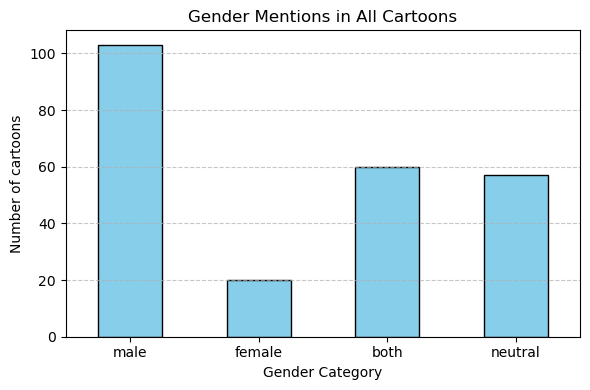

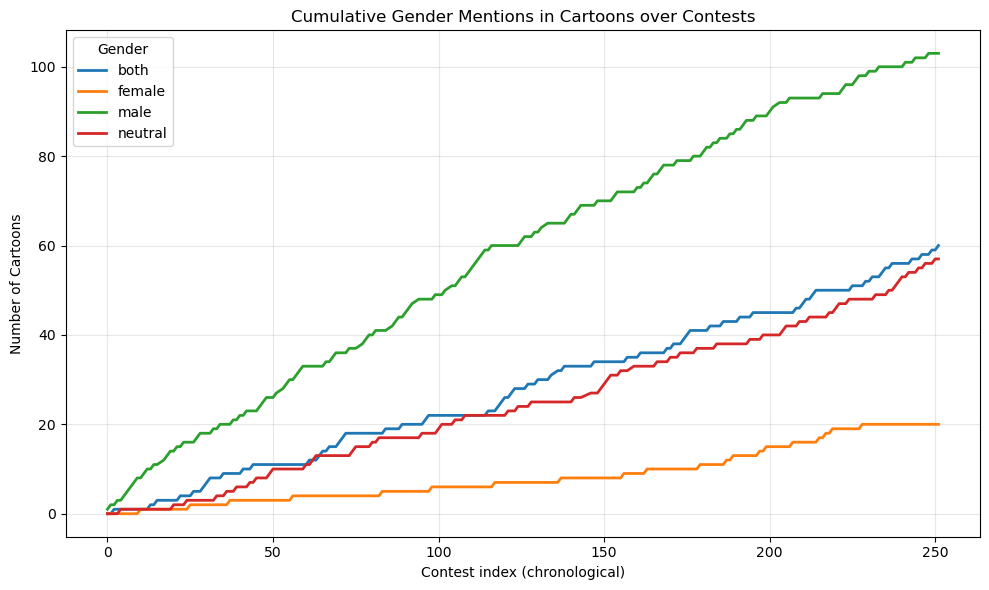

In [11]:
# How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender"
)


### How often men/women appear in the top 10 captions ?

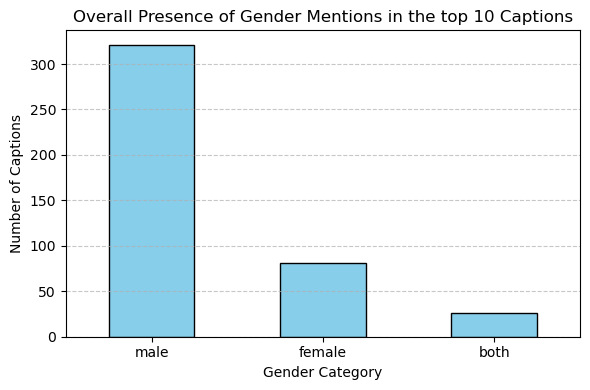

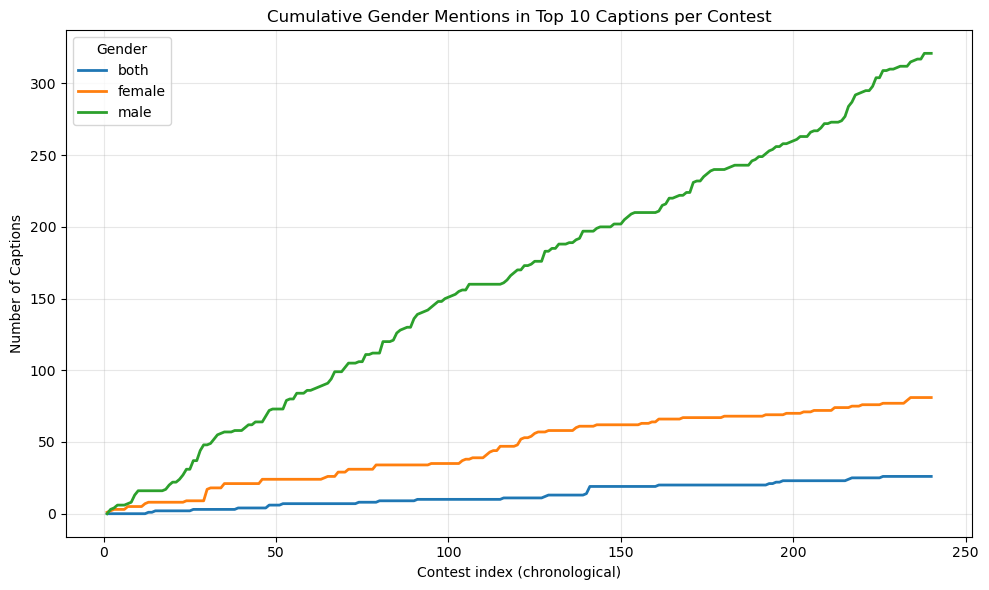

In [12]:
# How often men/women are mentionned in captions

overall_counts, pivoted = ga.distribution_captions(count)

# In the plots I don't show the neutral, because it is a huge number compared
# to the other categories

# Plot Overall counts
ga.plot_overall_counts(
    overall_counts,
    title="Overall Presence of Gender Mentions in the top 10 Captions",
    xlabel="Gender Category",
    ylabel="Number of Captions",
    neutral = False
)

# Evolution over time
cumulative = pivoted.cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    cumulative,
    title="Cumulative Gender Mentions in Top 10 Captions per Contest",
    xlabel="Contest index (chronological)",
    ylabel="Number of Captions",
    legend_title="Gender",
    neutral = False
)

### Heatmap

- Are men more mentionned when there is a man in the picture or not, same for women ? 
- Are men mentionned in the caption even if there are no men in the picture, same for women ? 
- Does the humor around one gender depends on referencing the other ? 

Let's look at cross-relationships between gender in the image and gender in the caption. Here we'll look at this relationship for the top voted caption.

In [13]:
cross = ga.compute_crosstab(no_NaN, dataA, dataC1)

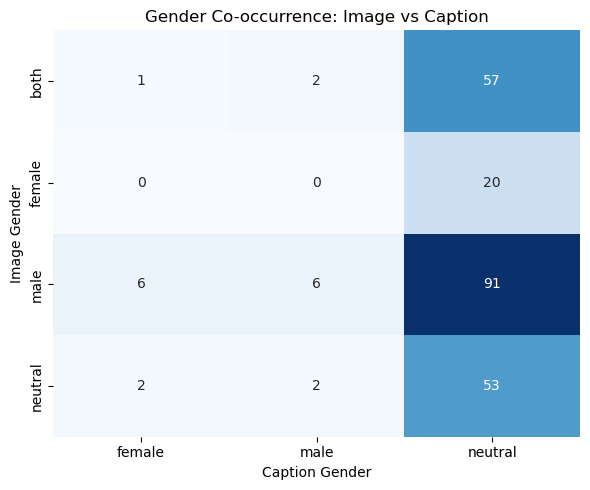

In [14]:
ga.plot_gender_cooccurrence(cross, title = "Gender Co-occurrence: Image vs Caption", 
                            xlabel="Caption Gender",
                            ylabel="Image Gender")

## 1. Dig a little deeper: How are men vs women depicted

**THANK YOU TO THIS GOAT**

https://nealcaren.github.io/text-as-data/html/times_gender.html

In [15]:
nltk.data.path

['C:\\Users\\Amélie/nltk_data',
 'd:\\Anaconda\\envs\\ada\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\share\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\lib\\nltk_data',
 'C:\\Users\\Amélie\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data']

In [16]:
# do only once !
nltk.download('punkt_tab', download_dir=r'D:\EPFL\MA3\Applied Data Analysis\nltk')
nltk.data.path.append(r'D:\EPFL\MA3\Applied Data Analysis\nltk')

[nltk_data] Downloading package punkt_tab to D:\EPFL\MA3\Applied Data
[nltk_data]     Analysis\nltk...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
nltk.data.path

['C:\\Users\\Amélie/nltk_data',
 'd:\\Anaconda\\envs\\ada\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\share\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\lib\\nltk_data',
 'C:\\Users\\Amélie\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data',
 'D:\\EPFL\\MA3\\Applied Data Analysis\\nltk']

In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

I set up the counters to store the various quantities of interest. These are the ones that modified in the increment_gender function. Some of the values probably don't need to be entered now, particularly for the word and sentence counters, but starting with zeroes helps remind me what they are for.

In [19]:
sexes=['male','female','none','both']

# count of the number of sentences in the text
sentence_counter={sex:0 for sex in sexes}

# counter of words that relate to the genders
word_counter={sex:0 for sex in sexes}

# frequency that a word is associated with one gender
word_freq={sex:{} for sex in sexes}

# dict of the proper nouns found
proper_nouns={}


In [20]:
# Let's look at the images

dataC1 = dataC.copy(deep=True)

 #remove the []
dataC1["image_descriptions"] = dataC1["image_descriptions"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

# check
# dataC1.sample(10)

The processing begins by splitting the sentence into words and removing punctuation. Then for each word that doesn't begin the sentence, I figure out if it is capitalized or not as part of the hunt for proper nouns. Then, I estimate whether the sentence is likely talking about a man or a woman, based on the occurrences of the various gender lists. Finally, I add word that is used to the appropriate gender word frequencies counter. So the sentence, "She is lovely." would add 'she','is', and 'lovely' to our count of words used when talking about a female. It would also increment the lower case counters for 'is' and 'lovely'.

In [21]:
ga.analyse_text(dataC1,tokenizer, punctuation, sentence_counter, word_counter, word_freq, proper_nouns, C = True)

In [22]:
# Let's see what this did
print(proper_nouns)
print(sentence_counter)
print(word_counter)
print(word_freq)

{'man': {'lower': 283}, 'is': {'lower': 708, 'upper': 1}, 'relaxing': {'lower': 4}, 'on': {'lower': 277}, 'a': {'lower': 991, 'upper': 2}, 'city': {'lower': 10}, 'street': {'lower': 6}, 'are': {'lower': 340}, 'going': {'lower': 9}, 'about': {'lower': 11}, 'their': {'lower': 39}, 'business': {'lower': 7}, 'and': {'lower': 252}, 'stepping': {'lower': 1}, 'him': {'lower': 85}, 'as': {'lower': 37}, 'they': {'lower': 16}, 'pass': {'lower': 2}, 'in': {'lower': 366}, 'winter': {'lower': 1}, 'coat': {'lower': 2}, 'cap': {'lower': 2}, 'looking': {'lower': 69}, 'at': {'lower': 218}, 'small': {'lower': 11}, 'bearded': {'lower': 1}, 'holding': {'lower': 31}, 'snow': {'lower': 6, 'upper': 2}, 'shovel': {'lower': 2}, 'much': {'lower': 1}, 'taller': {'lower': 1}, 'than': {'lower': 3}, 'ground': {'lower': 15}, 'covered': {'lower': 5}, 'except': {'lower': 1}, 'for': {'lower': 14}, 'path': {'lower': 3}, 'leading': {'lower': 3}, 'to': {'lower': 196}, 'house': {'lower': 16}, 'the': {'lower': 513}, 'boy': 

After all the descriptions are parsed, it is time to start analyzing the word frequencies.

First, I create a set consisting of all words which were capitalized more often than not.

In [23]:
proper_nouns=set([word for word in proper_nouns if  
                  proper_nouns[word].get('upper',0) / 
                  (proper_nouns[word].get('upper',0) + 
                   proper_nouns[word].get('lower',0))>.50])

In [24]:
proper_nouns

{'adam',
 'amish',
 'bbqing',
 'commandments',
 'death',
 'dumpty',
 'earth',
 'eden',
 'england',
 'era',
 'eve',
 'frankenstein',
 "genie's",
 'god',
 'greek',
 'humpty',
 'ivs',
 'jack',
 'liberty',
 'moses-like',
 'rapunzel',
 'repunzel',
 "sam's",
 'satan',
 'statue',
 'tv',
 'ufo',
 'victorian',
 'vikings',
 'white'}

In [25]:
len(proper_nouns)

30

I don't really care about rare words, so I select the top 1,000 words, based on frequencies, from both the male and female word dictionaries. From that list, I subtract the words used to identify the sentence as either male or female along with the proper nouns.

In [26]:
common_words=set([w for w in sorted (word_freq['female'],
                                     key=word_freq['female'].get,reverse=True)[:1000]]+[w for w in sorted (word_freq['male'],key=word_freq['male'].get,reverse=True)[:1000]])

common_words=list(common_words-set(ga.male_terms)-set(ga.female_terms)-proper_nouns)

In [27]:
len(common_words)

972

I compute how likely the word appears in a male subject sentence versus a female subject sentence. I also need to control for the fact that there is likely an imbalance in how many words are written about men and women. If 'hair' is mentioned in 10 male-subjected sentences and 10 female-subject sentences, that could be taken as a sign of parity, but not if there a total of 20 female-subject (50%) sentences and 100 male-subject sentences (10%). I'll score 'hair' as a 16.6% male, which is (10%)/(50%+10%). Later on, if we want, we can recover the ratios by computing (100-16.6)/16.6, which is 5x, the same as 50%/10%.

In [28]:
male_percent={word:(word_freq['male'].get(word,0) / word_counter['male']) 
              / (word_freq['female'].get(word,0) / word_counter['female']+word_freq['male'].get(word,0)/word_counter['male']) for word in common_words}

We can print out some basic statistics based on our counters about overall rates of coverage.

In [29]:
print('%.1f%% gendered' % (100*(sentence_counter['male']+sentence_counter['female'])/
                           (sentence_counter['male']+sentence_counter['female']+sentence_counter['both']+sentence_counter['none'])))
print('%s sentences about men.' % sentence_counter['male'])
print('%s sentences about women.' % sentence_counter['female'])
print('%.1f sentences about men for each sentence about women.' % (sentence_counter['male']/sentence_counter['female']))

38.3% gendered
418 sentences about men.
90 sentences about women.
4.6 sentences about men for each sentence about women.


Finally, I print out the words that are disproporately found in the male and female subject sentences. For the 50 distincitve female and male words, I print the ratio of gendered %s along with the count of the number of male-subject and female-subject sentences that had the word. This script isn't particularly pretty, but it gets the job done.

In [30]:
header ='Ratio\tMale\tFemale\tWord'

print('Male words')

print(header)

for word in sorted (male_percent,key=male_percent.get,reverse=True)[:50]:
    try:
        ratio=male_percent[word]/(1-male_percent[word])
    except:
        ratio=100
    print('%.1f\t%02d\t%02d\t%s' % (ratio,word_freq['male'].get(word,0),word_freq['female'].get(word,0),word))

print('\n'*2)
print('Female words')
print(header)
for word in sorted (male_percent,key=male_percent.get,reverse=False)[:50]:
    try:
        ratio=(1-male_percent[word])/male_percent[word]
    except:
        ratio=100
    print('%.1f\t%01d\t%01d\t%s' % (ratio,word_freq['male'].get(word,0),word_freq['female'].get(word,0),word))

Male words
Ratio	Male	Female	Word
100.0	01	00	burgers
100.0	02	00	work
100.0	02	00	wet
100.0	02	00	thing
100.0	01	00	guard
100.0	01	00	not
100.0	02	00	or
100.0	03	00	business
100.0	03	00	tie
100.0	01	00	shoveling
100.0	01	00	snail
100.0	02	00	bear
100.0	01	00	speech
100.0	01	00	plane
100.0	01	00	truck
100.0	03	00	soup
100.0	02	00	hammock
100.0	01	00	close
100.0	01	00	talks
100.0	01	00	straight
100.0	01	00	swallowing
100.0	02	00	interrupted
100.0	02	00	grocery
100.0	02	00	medieval
100.0	01	00	purchasing
100.0	01	00	donut
100.0	01	00	expecting
100.0	01	00	now
100.0	01	00	hamburger
100.0	02	00	grill
100.0	03	00	therapist
100.0	01	00	enjoys
100.0	02	00	board
100.0	01	00	mountains
100.0	01	00	fours
100.0	05	00	kitchen
100.0	05	00	trying
100.0	01	00	sad
100.0	01	00	seeing
100.0	02	00	skeleton
100.0	01	00	fending
100.0	01	00	clown
100.0	02	00	egg
100.0	01	00	dejected
100.0	01	00	occupied
100.0	01	00	ways
100.0	03	00	giving
100.0	01	00	cook
100.0	01	00	hangs
100.0	01	00	then



Female words
Ra

Try to interpret ? If your knowledge of men's and women's role in society just came from the descriptions of the cartoons, you would think ...

**Word clouds** 


In [ ]:
# outfile_name = 'gender.csv'
# with open(outfile_name, 'w', newline='', encoding='utf-8') as csv_outfile:
#     writer = csv.writer(csv_outfile)
#     writer.writerow(['percent_male', 'male_count', 'female_count', 'word'])

#     for word in common_words:
#         writer.writerow([
#             round(100 * male_percent[word], 2),
#             word_freq['male'].get(word, 0),
#             word_freq['female'].get(word, 0),
#             word
#         ])

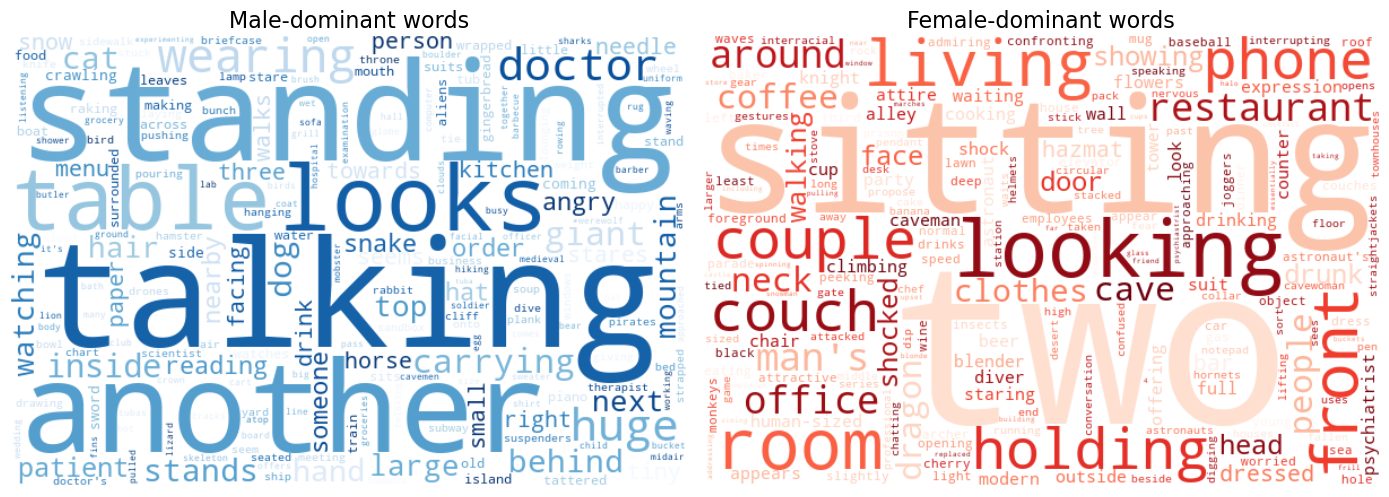

In [ ]:
# --- Load the CSV data ---
df = pd.read_csv(r'src\data\gender_roles_data\gender.csv')

# --- Create two subsets: one for male-dominant and one for female-dominant words ---
male_words = df[df['percent_male'] > 50]
female_words = df[df['percent_male'] < 50]

# --- Build frequency dictionaries for each group ---
male_freq = dict(zip(male_words['word'], male_words['male_count']))
female_freq = dict(zip(female_words['word'], female_words['female_count']))

# --- Remove stopwords from both frequency dictionaries ---
male_freq = {word: freq for word, freq in male_freq.items() if word.lower() not in ga.STOPWORDS}
female_freq = {word: freq for word, freq in female_freq.items() if word.lower() not in ga.STOPWORDS}

# --- Generate the word clouds ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=200,
    stopwords=ga.STOPWORDS
).generate_from_frequencies(male_freq)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200,
    stopwords=ga.STOPWORDS
).generate_from_frequencies(female_freq)

# # --- Display both word clouds side by side ---
ga.plot_wordclouds(male_cloud, female_cloud)

In [ ]:
# save the male and female freq to display the world cloud in results.ipynb

# with open("male_freq.json", "w") as f:
#     json.dump(male_freq, f)

# with open("female_freq.json", "w") as f:
#     json.dump(female_freq, f)

# # Load it back
# with open("my_dict.json", "r") as f:
#     loaded_dict = json.load(f)

# in the results
# # --- Generate the word clouds ---
# male_cloud = WordCloud(
#     width=600,
#     height=400,
#     background_color='white',
#     colormap='Blues',
#     max_words=200,
#     stopwords=ga.STOPWORDS
# ).generate_from_frequencies(male_freq)

# female_cloud = WordCloud(
#     width=600,
#     height=400,
#     background_color='white',
#     colormap='Reds',
#     max_words=200,
#     stopwords=ga.STOPWORDS
# ).generate_from_frequencies(female_freq)

# # # --- Display both word clouds side by side ---
# ga.plot_wordclouds(male_cloud, female_cloud)

**Interpretation needed**

As an addendum, we can look at the most popular words. In this case, we will look at the 100 most frequently used words, and then compare what proportion of male subject sentences had those words and what proportion of female subject sentences had those words.

In [34]:
# --- Collect all words, excluding stopwords ---
all_words = [w for w in word_freq['none']] + \
            [w for w in word_freq['both']] + \
            [w for w in word_freq['male']] + \
            [w for w in word_freq['female']]

# --- Create dictionary with counts, filter out stopwords ---
all_words = {
    w: (word_freq['male'].get(w,0) + word_freq['female'].get(w,0) +
        word_freq['both'].get(w,0) + word_freq['none'].get(w,0))
    for w in set(all_words)
    if w.lower() not in ga.STOPWORDS
}

# --- Print top 100 words ---
print('word\tMale\tFemale')
for word in sorted(all_words, key=all_words.get, reverse=True)[:100]:
    male_pct = 100 * word_freq['male'].get(word,0) / sentence_counter['male']
    female_pct = 100 * word_freq['female'].get(word,0) / sentence_counter['female']
    print(f'{word}\t{male_pct:.1f}%\t{female_pct:.1f}%')

word	Male	Female
man	52.2%	0.0%
two	10.0%	13.3%
nan	0.0%	0.0%
woman	0.0%	62.2%
people	1.2%	3.3%
sitting	8.1%	11.1%
talking	7.4%	6.7%
looking	6.2%	8.9%
standing	6.2%	2.2%
looks	5.3%	4.4%
room	2.6%	6.7%
men	9.8%	0.0%
another	5.3%	1.1%
table	4.8%	4.4%
couple	1.0%	4.4%
giant	2.9%	2.2%
look	2.2%	2.2%
office	4.1%	4.4%
front	3.3%	5.6%
holding	4.5%	4.4%
wearing	3.1%	1.1%
outside	0.5%	2.2%
walking	1.2%	3.3%
inside	2.6%	1.1%
around	1.9%	4.4%
huge	2.9%	2.2%
behind	2.4%	1.1%
restaurant	2.4%	4.4%
watching	1.9%	1.1%
staring	1.2%	2.2%
face	1.9%	3.3%
living	0.2%	5.6%
top	1.9%	0.0%
next	1.9%	1.1%
couch	0.7%	4.4%
waiter	4.3%	0.0%
three	1.2%	1.1%
dog	2.4%	0.0%
head	1.4%	3.3%
doctor	2.9%	0.0%
large	1.9%	1.1%
bunch	0.7%	0.0%
carrying	2.9%	1.1%
person	1.2%	1.1%
house	0.7%	1.1%
fish	0.2%	0.0%
caveman	1.0%	2.2%
king	3.6%	0.0%
cave	1.2%	3.3%
they're	0.0%	0.0%
door	0.7%	3.3%
bar	1.0%	2.2%
island	1.0%	0.0%
angry	1.4%	1.1%
middle	1.0%	1.1%
ground	0.5%	0.0%
boy	3.3%	0.0%
appears	0.7%	2.2%
knight	1.2%	2.2%
store	0.